In [33]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
import wandb

# Set Seed
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

set_seed(42)

# Check Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {DEVICE}")

# Login to WandB (Replace with your key if needed, or rely on previous login)
# wandb.login(key="YOUR_KEY_HERE")

✅ Using device: cuda


In [34]:
# --- Configuration ---
BIDS_ROOT = '/ocean/projects/cis250019p/gandotra/11785-gp-eeg/ds005589'
IMAGE_DIR = '/ocean/projects/cis250019p/gandotra/11785-gp-eeg/images'
CAPTIONS_FILE = '/ocean/projects/cis250019p/gandotra/11785-gp-eeg/captions.txt'

ALL_SUBJECTS = ['sub-02', 'sub-03', 'sub-05', 'sub-09', 'sub-14', 'sub-15', 
                'sub-17', 'sub-19', 'sub-20', 'sub-23', 'sub-24', 'sub-28', 'sub-29']

CONFIG = {
    "epochs": 50,           # 50 Epochs should be enough to see >8%
    "batch_size": 32,
    "lr": 1e-3,             # Higher LR because CNNs handle it well
    "weight_decay": 1e-4,   # Regularization
    "patience": 10          # Early stopping
}

In [48]:
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm

class EEG_Paper_Replication_Dataset(Dataset):
    def __init__(self, bids_root, images_dir, captions_path, 
                 subject_list, session_list, 
                 clamp_thres=500, stats=None):
        
        self.bids_root = bids_root
        self.images_dir = images_dir
        self.clamp_thres = clamp_thres
        self.trial_metadata = []
        
        # 1. Load Captions Helper
        self.captions_dict = self._load_captions(captions_path)
        self.category_to_idx = {cat: i for i, cat in enumerate(sorted(set(c for c, _ in self.captions_dict.values())))}
        
        # 2. Scan Metadata
        print(f"Scanning metadata for {session_list}...")
        for sub in subject_list:
            for ses in session_list:
                for run in ['01', '02', '03', '04']:
                    session_path = os.path.join(self.bids_root, sub, ses)
                    csv_path = os.path.join(session_path, f"{sub}_{ses}_task-lowSpeed_run-{run}_image.csv")
                    npy_path = os.path.join(session_path, f"{sub}_{ses}_task-lowSpeed_run-{run}_1000Hz.npy")
                    
                    if not (os.path.exists(csv_path) and os.path.exists(npy_path)):
                        continue
                        
                    try:
                        csv_data = pd.read_csv(csv_path)
                        for i, row in csv_data.iterrows():
                            img_base_name = self._get_base_name(row['FilePath'])
                            if not img_base_name: continue
                            
                            category, caption = self.captions_dict.get(img_base_name, (None, None))
                            if not category: continue
                            
                            self.trial_metadata.append({
                                'npy_path': npy_path,
                                'trial_index': i,
                                'label': self.category_to_idx[category],
                                'subject_id': 0 # Placeholder if not needed for FC model
                            })
                    except:
                        continue
        
        print(f"Found {len(self.trial_metadata)} trials.")

        # 3. Compute Global Statistics (The Paper's Method)
        if stats is None:
            print("Computing Global Statistics (this takes ~1 min)...")
            self.mean, self.std = self._compute_global_stats()
        else:
            self.mean, self.std = stats

    def _compute_global_stats(self):
        # We use a subset (every 10th sample) to estimate global mean/std 
        # because loading 100% of data into RAM is impossible.
        subset_indices = range(0, len(self.trial_metadata), 10)
        
        sum_x = 0
        sum_sq_x = 0
        count = 0
        
        for i in tqdm(subset_indices, desc="Calculating Stats"):
            meta = self.trial_metadata[i]
            d = np.load(meta['npy_path'])[meta['trial_index']]
            d = np.clip(d, -self.clamp_thres, self.clamp_thres)
            
            sum_x += np.mean(d) # Mean of this trial
            sum_sq_x += np.mean(d**2) # Mean square of this trial
            count += 1
            
        # E[X]
        global_mean = sum_x / count
        # Var(X) = E[X^2] - (E[X])^2
        global_std = np.sqrt((sum_sq_x / count) - (global_mean**2))
        
        print(f"Global Mean: {global_mean:.4f}, Global Std: {global_std:.4f}")
        return float(global_mean), float(global_std)

    def get_stats(self):
        """Returns the calculated (mean, std) tuple."""
        return self.mean, self.std

    def _load_captions(self, path):
        d = {}
        with open(path, 'r') as f:
            next(f)
            for line in f:
                parts = line.strip().split('\t')
                if len(parts) >= 4:
                    d[parts[2]] = (parts[1], parts[3])
        return d

    def _get_base_name(self, p):
        try:
            bn = os.path.splitext(os.path.basename(str(p).replace('\\', '/')))[0]
            if bn.endswith('_resized'): return bn[:-8]
            return bn
        except: return None

    def __len__(self):
        return len(self.trial_metadata)

    def __getitem__(self, idx):
        meta = self.trial_metadata[idx]
        eeg_data = np.load(meta['npy_path'])[meta['trial_index']]
        eeg_data = np.clip(eeg_data, -self.clamp_thres, self.clamp_thres)
        
        # Global Normalization
        eeg_data = (eeg_data - self.mean) / (self.std + 1e-6)
        
        return (torch.tensor(eeg_data, dtype=torch.float32), 
                torch.tensor(meta['label'], dtype=torch.long),
                0) # Dummy subject ID

Initializing Dataset...
Scanning files for subjects: ['sub-02']...
Found 2000 valid trials.
Skipping global stats computation (Visualization Mode).
Searching for 'dog' trials...


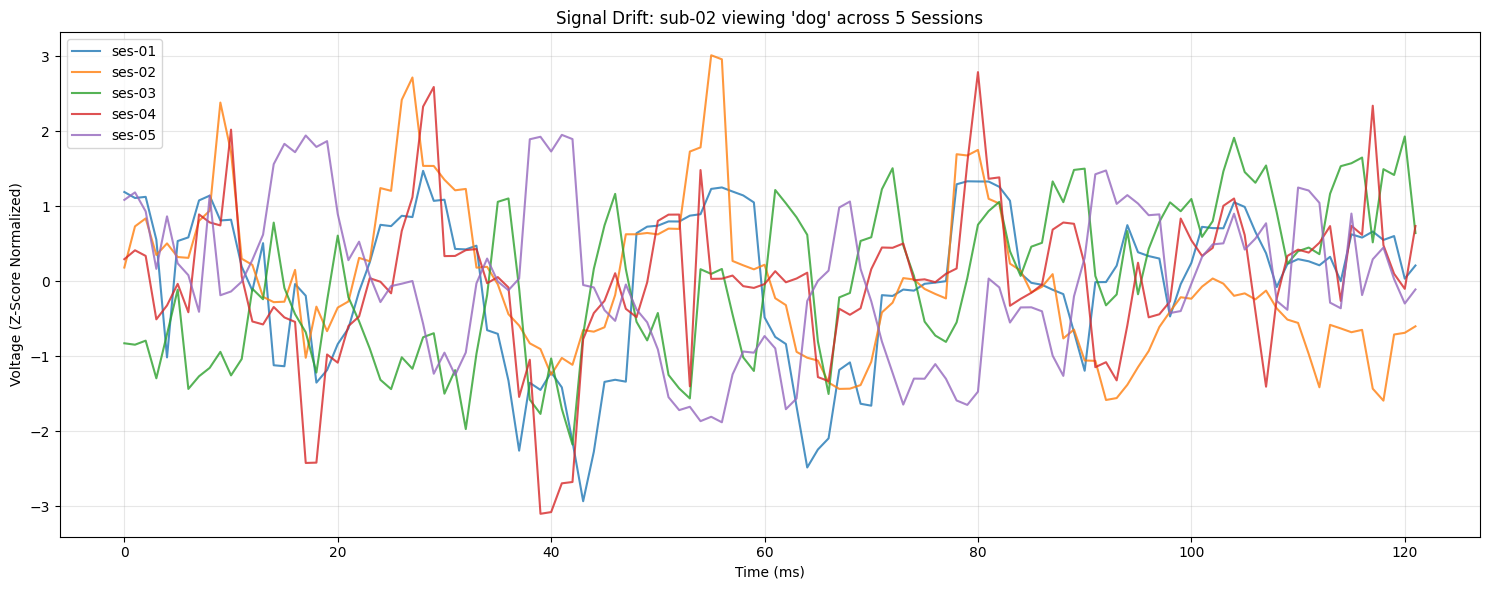

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import re
import pandas as pd
import os
from torch.utils.data import Dataset
from tqdm.notebook import tqdm

# --- Configuration ---
SUBJECT_TO_PLOT = 'sub-02'
CATEGORY_TO_PLOT = 'dog'
CHANNEL_IDX = 20
# Paths
CAPTIONS_FILE = '/ocean/projects/cis250019p/gandotra/11785-gp-eeg/captions.txt'
BIDS_ROOT = '/ocean/projects/cis250019p/gandotra/11785-gp-eeg/ds005589'
IMAGE_DIR = '/ocean/projects/cis250019p/gandotra/11785-gp-eeg/images'

# --- 1. FULL DATASET CLASS (With Loading Logic Included) ---
class EEG_Paper_Replication_Dataset(Dataset):
    def __init__(self, bids_root, images_dir, captions_path, 
                 subject_list, session_list, 
                 clamp_thres=500, stats=None):
        
        self.bids_root = bids_root
        self.images_dir = images_dir
        self.clamp_thres = clamp_thres
        self.trial_metadata = []
        
        # 1. Load Captions
        self.captions_dict = self._load_captions(captions_path)
        
        # 2. SCAN FILES (This was missing in your previous run)
        print(f"Scanning files for subjects: {subject_list}...")
        for sub in subject_list:
            for ses in session_list:
                for run in ['01', '02', '03', '04']:
                    session_path = os.path.join(self.bids_root, sub, ses)
                    
                    # File paths
                    csv_path = os.path.join(session_path, f"{sub}_{ses}_task-lowSpeed_run-{run}_image.csv")
                    npy_path = os.path.join(session_path, f"{sub}_{ses}_task-lowSpeed_run-{run}_1000Hz.npy")
                    
                    if not (os.path.exists(csv_path) and os.path.exists(npy_path)):
                        continue
                        
                    try:
                        csv_data = pd.read_csv(csv_path)
                        # Iterate through rows to build metadata
                        for i, row in csv_data.iterrows():
                            img_base_name = self._get_base_name(row['FilePath'])
                            if not img_base_name: continue
                            
                            category, caption = self.captions_dict.get(img_base_name, (None, None))
                            if not category: continue
                            
                            # Store metadata
                            self.trial_metadata.append({
                                'npy_path': npy_path,
                                'trial_index': i,
                                'category': category, # Store string directly for easy matching
                                'session': ses,
                                'subject': sub
                            })
                    except Exception as e:
                        continue

        print(f"Found {len(self.trial_metadata)} valid trials.")
        
        # 3. Handle Stats (Skip if (0,1) is passed for visualization)
        if stats == (0, 1):
            print("Skipping global stats computation (Visualization Mode).")
            self.mean, self.std = 0, 1
        elif stats is None:
            self.mean, self.std = 0, 1 # Placeholder if needed later
        else:
            self.mean, self.std = stats

    def _load_captions(self, captions_path):
        captions_dict = {}
        with open(captions_path, 'r') as f:
            next(f) 
            for line in f:
                parts = line.strip().split('\t')
                if len(parts) >= 4:
                    _, category, img_name, caption = parts
                    captions_dict[img_name] = (category, caption)
        return captions_dict

    def _get_base_name(self, file_path):
        try:
            bn = os.path.splitext(os.path.basename(str(file_path).replace('\\', '/')))[0]
            if bn.endswith('_resized'): return bn[:-8]
            return bn
        except: return None

    def __len__(self):
        return len(self.trial_metadata)

# --- 2. EXECUTE VISUALIZATION ---
print("Initializing Dataset...")
# We pass stats=(0,1) to skip any heavy computation, just loading metadata
viz_dataset = EEG_Paper_Replication_Dataset(
    bids_root=BIDS_ROOT,
    images_dir=IMAGE_DIR,
    captions_path=CAPTIONS_FILE,
    subject_list=[SUBJECT_TO_PLOT],
    session_list=['ses-01', 'ses-02', 'ses-03', 'ses-04', 'ses-05'],
    stats=(0, 1) 
)

# Extract and Plot
session_signals = {}
print(f"Searching for '{CATEGORY_TO_PLOT}' trials...")

for item in viz_dataset.trial_metadata:
    # Direct string match is safer
    if item['category'] == CATEGORY_TO_PLOT:
        sess = item['session']
        
        # If we haven't found an example for this session yet, grab it
        if sess not in session_signals:
            try:
                full_npy = np.load(item['npy_path'])
                eeg_data = full_npy[item['trial_index']] # Shape (122, 500)
                session_signals[sess] = eeg_data
            except Exception as e:
                print(f"Error loading {sess}: {e}")
        
        if len(session_signals) == 5:
            break

# Plotting
plt.figure(figsize=(15, 6))
plt.title(f"Signal Drift: {SUBJECT_TO_PLOT} viewing '{CATEGORY_TO_PLOT}' across 5 Sessions")
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (Z-Score Normalized)")

sessions = sorted(session_signals.keys())
if len(sessions) == 0:
    print(f"❌ No matches found for {CATEGORY_TO_PLOT}. Check spelling or dataset path.")
else:
    for sess in sessions:
        signal = session_signals[sess][CHANNEL_IDX]
        
        # Normalize for visualization (so they overlay nicely)
        signal = (signal - signal.mean()) / (signal.std() + 1e-6)
        
        plt.plot(signal, label=sess, alpha=0.8, linewidth=1.5)

    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [49]:
# --- Configuration ---
BIDS_ROOT = '/ocean/projects/cis250019p/gandotra/11785-gp-eeg/ds005589'
IMAGE_DIR = '/ocean/projects/cis250019p/gandotra/11785-gp-eeg/images'
CAPTIONS_FILE = '/ocean/projects/cis250019p/gandotra/11785-gp-eeg/captions.txt'
ALL_SUBJECTS = ['sub-02', 'sub-03', 'sub-05', 'sub-09', 'sub-14', 'sub-15', 
                'sub-17', 'sub-19', 'sub-20', 'sub-23', 'sub-24', 'sub-28', 'sub-29']
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Create Datasets
print("--- Init Train Dataset ---")
train_ds = EEG_Paper_Replication_Dataset(
    bids_root=BIDS_ROOT, 
    images_dir=IMAGE_DIR, 
    captions_path=CAPTIONS_FILE, 
    subject_list=ALL_SUBJECTS,
    session_list=['ses-01', 'ses-02', 'ses-03']
)
stats = train_ds.get_stats() # <--- This will work now!

print("\n--- Init Validation Dataset ---")
val_ds = EEG_Paper_Replication_Dataset(
    bids_root=BIDS_ROOT, 
    images_dir=IMAGE_DIR, 
    captions_path=CAPTIONS_FILE, 
    subject_list=ALL_SUBJECTS,
    session_list=['ses-04'], 
    stats=stats
)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=4)

# 2. Define Model (Fully Connected)
class Paper_FC_Model(nn.Module):
    def __init__(self, num_classes=20):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(122 * 500, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    def forward(self, x, sub_id=None):
        return self.net(x)

model = Paper_FC_Model(num_classes=20).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()

# 3. Training Loop
print(f"\n🚀 Starting Training (Target: >10%)...")
best_val_acc = 0

for epoch in range(1, 31):
    model.train()
    correct = 0
    total = 0
    total_loss = 0
    
    # Train
    for eeg, label, _ in tqdm(train_loader, desc=f"Epoch {epoch}", leave=False):
        eeg, label = eeg.to(DEVICE), label.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(eeg)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, pred = outputs.max(1)
        correct += pred.eq(label).sum().item()
        total += label.size(0)
        
    train_acc = 100. * correct / total
    
    # Validate
    model.eval()
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for eeg, label, _ in val_loader:
            eeg, label = eeg.to(DEVICE), label.to(DEVICE)
            outputs = model(eeg)
            _, pred = outputs.max(1)
            val_correct += pred.eq(label).sum().item()
            val_total += label.size(0)
            
    val_acc = 100. * val_correct / val_total
    print(f"Epoch {epoch:02d}: Train Acc {train_acc:.2f}% | Val Acc {val_acc:.2f}%")
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model_fc_paper.pth")
        print(f"  ✅ Best Model Saved!")

--- Init Train Dataset ---
Scanning metadata for ['ses-01', 'ses-02', 'ses-03']...
Found 15600 trials.
Computing Global Statistics (this takes ~1 min)...


Calculating Stats:   0%|          | 0/1560 [00:00<?, ?it/s]

Global Mean: -0.4406, Global Std: 25.0127

--- Init Validation Dataset ---
Scanning metadata for ['ses-04']...
Found 5200 trials.

🚀 Starting Training (Target: >10%)...


Epoch 1:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch 01: Train Acc 5.47% | Val Acc 6.96%
  ✅ Best Model Saved!


Epoch 2:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch 02: Train Acc 6.74% | Val Acc 7.00%
  ✅ Best Model Saved!


Epoch 3:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch 03: Train Acc 7.85% | Val Acc 7.79%
  ✅ Best Model Saved!


Epoch 4:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch 04: Train Acc 8.87% | Val Acc 7.90%
  ✅ Best Model Saved!


Epoch 5:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch 05: Train Acc 9.29% | Val Acc 8.04%
  ✅ Best Model Saved!


Epoch 6:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch 06: Train Acc 10.10% | Val Acc 8.21%
  ✅ Best Model Saved!


Epoch 7:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch 07: Train Acc 10.76% | Val Acc 8.88%
  ✅ Best Model Saved!


Epoch 8:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch 08: Train Acc 11.19% | Val Acc 8.21%


Epoch 9:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch 09: Train Acc 11.29% | Val Acc 9.02%
  ✅ Best Model Saved!


Epoch 10:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch 10: Train Acc 11.66% | Val Acc 8.90%


Epoch 11:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch 11: Train Acc 11.79% | Val Acc 8.38%


Epoch 12:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch 12: Train Acc 12.24% | Val Acc 8.62%


Epoch 13:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch 13: Train Acc 12.58% | Val Acc 8.56%


Epoch 14:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch 14: Train Acc 12.54% | Val Acc 8.98%


Epoch 15:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch 15: Train Acc 13.08% | Val Acc 9.12%
  ✅ Best Model Saved!


Epoch 16:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch 16: Train Acc 13.49% | Val Acc 9.06%


Epoch 17:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch 17: Train Acc 13.85% | Val Acc 9.79%
  ✅ Best Model Saved!


Epoch 18:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch 18: Train Acc 14.31% | Val Acc 9.08%


Epoch 19:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch 19: Train Acc 14.06% | Val Acc 8.77%


Epoch 20:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch 20: Train Acc 14.58% | Val Acc 9.27%


Epoch 21:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch 21: Train Acc 14.99% | Val Acc 9.10%


Epoch 22:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch 22: Train Acc 14.97% | Val Acc 9.52%


Epoch 23:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch 23: Train Acc 15.61% | Val Acc 9.29%


Epoch 24:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch 24: Train Acc 16.01% | Val Acc 9.29%


Epoch 25:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch 25: Train Acc 16.03% | Val Acc 9.15%


Epoch 26:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch 26: Train Acc 16.20% | Val Acc 8.69%


Epoch 27:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch 27: Train Acc 17.13% | Val Acc 9.63%


Epoch 28:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch 28: Train Acc 16.76% | Val Acc 9.71%


Epoch 29:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch 29: Train Acc 16.88% | Val Acc 9.02%


Epoch 30:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch 30: Train Acc 17.35% | Val Acc 9.17%


In [59]:
class EEG_ViT_1D(nn.Module):
    def __init__(self, num_subjects=13, num_classes=20):
        super().__init__()
        
        # --- Hyperparameters ---
        self.patch_size = 50      # 50ms window 
        self.stride = 25          # 50% overlap
        self.embed_dim = 128      # Feature size
        self.num_heads = 4
        self.depth = 2
        
        # --- 1. Tokenizer (The "Patchify" Step) ---
        # Input: (Batch, 122, 500) -> Output: (Batch, 128, ~19)
        self.tokenizer = nn.Sequential(
            nn.Conv1d(122, self.embed_dim, kernel_size=self.patch_size, stride=self.stride, padding=0),
            nn.BatchNorm1d(self.embed_dim),
            nn.LeakyReLU(0.1)
        )
        
        # --- 2. Learnable "Class Token" ---
        self.cls_token = nn.Parameter(torch.randn(1, 1, self.embed_dim))
        
        # --- 3. Positional Embedding ---
        self.pos_embedding = nn.Parameter(torch.randn(1, 32, self.embed_dim) * 0.01)
        
        # --- 4. Transformer Encoder ---
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=self.embed_dim, 
            nhead=self.num_heads, 
            dim_feedforward=512, 
            dropout=0.5, 
            batch_first=True,
            norm_first=True 
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=self.depth)
        
        # --- 5. Subject-Specific Heads ---
        self.heads = nn.ModuleList([
            nn.Linear(self.embed_dim, num_classes) for _ in range(num_subjects)
        ])

    def forward(self, x, subject_ids):
        # 🔍 AUTO-CORRECT INPUT SHAPE
        # Input comes in as (Batch, 500, 122) -> We need (Batch, 122, 500)
        if x.shape[1] == 500 and x.shape[2] == 122:
            x = x.permute(0, 2, 1)
            
        # 🛡️ Safety Crop (in case data is >500)
        if x.shape[2] > 500:
            x = x[:, :, :500]
            
        # ----------------------------------------
        
        # 1. Tokenize
        x = self.tokenizer(x)     # Output: (Batch, 128, 19)
        x = x.permute(0, 2, 1)    # Output: (Batch, 19, 128) -> (Batch, Seq, Dim)
        
        b, seq_len, _ = x.shape
        
        # 2. Append CLS Token
        cls_tokens = self.cls_token.expand(b, -1, -1) 
        x = torch.cat((cls_tokens, x), dim=1) # (Batch, 20, 128)
        
        # 3. Add Positional Embedding
        x = x + self.pos_embedding[:, :seq_len + 1, :]
        
        # 4. Transformer Attention
        x = self.transformer(x)
        
        # 5. Extract ONLY the CLS token output
        cls_output = x[:, 0, :]   # (Batch, 128)
        
        # 6. Subject Routing
        logits = torch.zeros(x.shape[0], 20).to(x.device)
        unique_subs = torch.unique(subject_ids)
        
        for sub in unique_subs:
            mask = (subject_ids == sub)
            logits[mask] = self.heads[sub.long()](cls_output[mask])
            
        return logits

In [60]:
# 1. Initialize
model = EEG_ViT_1D(num_subjects=13, num_classes=20).to(DEVICE)
print(f"Model Parameters: {sum(p.numel() for p in model.parameters()):,}")

# 2. Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()

# 3. Training Loop
print(f"\n🚀 Starting Scientific 1D-ViT Training...")
best_val_acc = 0

for epoch in range(1, 31):
    model.train()
    correct = 0
    total = 0
    
    # Train
    for eeg, label, sub_id in tqdm(train_loader, desc=f"Epoch {epoch}", leave=False):
        eeg, label, sub_id = eeg.to(DEVICE), label.to(DEVICE), sub_id.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(eeg, sub_id)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()
        
        _, pred = outputs.max(1)
        correct += pred.eq(label).sum().item()
        total += label.size(0)
        
    train_acc = 100. * correct / total
    
    # Validate
    model.eval()
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for eeg, label, sub_id in val_loader:
            eeg, label, sub_id = eeg.to(DEVICE), label.to(DEVICE), sub_id.to(DEVICE)
            outputs = model(eeg, sub_id)
            _, pred = outputs.max(1)
            val_correct += pred.eq(label).sum().item()
            val_total += label.size(0)
            
    val_acc = 100. * val_correct / val_total
    
    print(f"Epoch {epoch:02d}: Train Acc {train_acc:.2f}% | Val Acc {val_acc:.2f}%")
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model_vit_1d.pth")
        print(f"  ✅ Best Model Saved!")

Model Parameters: 1,215,492

🚀 Starting Scientific 1D-ViT Training...


Epoch 1:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch 01: Train Acc 5.55% | Val Acc 5.73%
  ✅ Best Model Saved!


Epoch 2:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch 02: Train Acc 5.81% | Val Acc 5.79%
  ✅ Best Model Saved!


Epoch 3:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch 03: Train Acc 6.04% | Val Acc 6.25%
  ✅ Best Model Saved!


Epoch 4:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch 04: Train Acc 6.17% | Val Acc 5.69%


Epoch 5:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch 05: Train Acc 5.87% | Val Acc 6.13%


Epoch 6:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch 06: Train Acc 6.45% | Val Acc 5.96%


Epoch 7:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch 07: Train Acc 6.62% | Val Acc 6.44%
  ✅ Best Model Saved!


Epoch 8:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch 08: Train Acc 6.71% | Val Acc 6.38%


Epoch 9:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch 09: Train Acc 6.67% | Val Acc 5.75%


Epoch 10:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch 10: Train Acc 6.80% | Val Acc 6.62%
  ✅ Best Model Saved!


Epoch 11:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch 11: Train Acc 6.71% | Val Acc 6.46%


Epoch 12:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch 12: Train Acc 6.78% | Val Acc 7.08%
  ✅ Best Model Saved!


Epoch 13:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch 13: Train Acc 7.10% | Val Acc 6.60%


Epoch 14:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch 14: Train Acc 6.87% | Val Acc 7.13%
  ✅ Best Model Saved!


Epoch 15:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch 15: Train Acc 7.27% | Val Acc 7.06%


Epoch 16:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch 16: Train Acc 7.05% | Val Acc 6.73%


Epoch 17:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch 17: Train Acc 7.38% | Val Acc 6.73%


Epoch 18:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch 18: Train Acc 7.26% | Val Acc 7.12%


Epoch 19:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch 19: Train Acc 7.14% | Val Acc 6.90%


Epoch 20:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch 20: Train Acc 7.38% | Val Acc 7.42%
  ✅ Best Model Saved!


Epoch 21:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch 21: Train Acc 7.40% | Val Acc 6.92%


Epoch 22:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch 22: Train Acc 7.57% | Val Acc 6.73%


Epoch 23:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch 23: Train Acc 7.51% | Val Acc 7.35%


Epoch 24:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch 24: Train Acc 7.65% | Val Acc 7.12%


Epoch 25:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch 25: Train Acc 7.78% | Val Acc 7.46%
  ✅ Best Model Saved!


Epoch 26:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch 26: Train Acc 8.19% | Val Acc 7.52%
  ✅ Best Model Saved!


Epoch 27:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch 27: Train Acc 8.01% | Val Acc 8.21%
  ✅ Best Model Saved!


Epoch 28:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch 28: Train Acc 7.83% | Val Acc 7.40%


Epoch 29:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch 29: Train Acc 7.91% | Val Acc 6.81%


Epoch 30:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch 30: Train Acc 7.65% | Val Acc 7.37%
